In [1]:
import cv2
import numpy as np
from pathlib import Path
from skimage.feature import hog
import os
from io import BytesIO
from skimage.filters import threshold_otsu
from PIL import Image as PILImage, UnidentifiedImageError
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from joblib import dump

C:\Users\PANDEY\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
dataset_path = Path('C:/Users/PANDEY/MiniProject/rice leaf diseases dataset')

In [3]:
# Function to load images and labels
def load_images_and_labels(folder_path, target_size=(300, 300)):
    images = []
    labels = []
    class_names = os.listdir(folder_path)

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Read the image in color
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            # Convert the image to grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Enhance brown spots by adjusting the intensity values
            enhanced_image = cv2.addWeighted(img_gray, 1.5, np.zeros_like(img_gray), 0, 50)

            # Resize the image
            img_resized = cv2.resize(enhanced_image, target_size)

            images.append(img_resized)
            labels.append(class_name)

    return np.array(images), np.array(labels)

In [4]:
# Load images and labels
images, labels = load_images_and_labels(dataset_path, target_size=(300, 300))

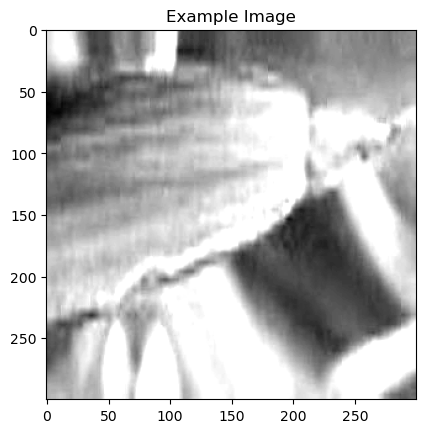

In [5]:
if images.any():
    plt.imshow(images[0], cmap='gray')
    plt.title("Example Image")
    plt.show()
else: 
    print("No images loaded.")

In [6]:
# Extract HOG features for each image
hog_features = [hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), block_norm='L2-Hys') for image in images]

In [7]:
# Flatten the HOG features
X = np.array(hog_features)
y = labels

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Standardize the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3747, 45000)
Shape of X_test: (937, 45000)
Shape of y_train: (3747,)
Shape of y_test: (937,)


SVM models using different kernel parameter

In [11]:
# Train the SVM model
model_1 = SVC(kernel='linear', C=1.0)
model_1.fit(X_train, y_train)
model_2 = SVC(kernel='rbf', gamma = 'scale')
model_2.fit(X_train, y_train)
model_3 = SVC(kernel='rbf', gamma = 'auto')
model_3.fit(X_train, y_train)
model_4 = SVC(kernel='poly', degree =3)
model_4.fit(X_train, y_train)
model_5 = SVC(kernel='sigmoid')
model_5.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [12]:
# Make predictions on the test set
y_pred1 = model_1.predict(X_test)
y_pred2 = model_2.predict(X_test)
y_pred3 = model_3.predict(X_test)
y_pred4 = model_4.predict(X_test)
y_pred5 = model_5.predict(X_test)

In [13]:
# Calculate and print accuracy for each model
accuracy_1 = accuracy_score(y_test, y_pred1)
accuracy_2 = accuracy_score(y_test, y_pred2)
accuracy_3 = accuracy_score(y_test, y_pred3)
accuracy_4 = accuracy_score(y_test, y_pred4)
accuracy_5 = accuracy_score(y_test, y_pred5)

print("Accuracy of model_1:", accuracy_1)
print("Accuracy of model_2:", accuracy_2)
print("Accuracy of model_3:", accuracy_3)
print("Accuracy of model_4:", accuracy_4)
print("Accuracy of model_5:", accuracy_5)

Accuracy of model_1: 0.9818569903948773
Accuracy of model_2: 0.9477054429028815
Accuracy of model_3: 0.9477054429028815
Accuracy of model_4: 0.9487726787620064
Accuracy of model_5: 0.8964781216648879


Ensemble ML model using SVM

In [14]:
# Define individual models
model_1 = SVC(kernel='linear', C=1.0)
model_2 = SVC(kernel='rbf')
model_3 = SVC(kernel='poly', degree=3)
model_4 = SVC(kernel='sigmoid')

# Create an ensemble model using voting
voting_model = VotingClassifier(
    estimators=[
        ('linear', model_1),
        ('rbf', model_2),
        ('poly', model_3),
        ('sigmoid', model_4)
    ],
    voting='hard'  # 'hard' for majority voting, 'soft' for weighted voting
)

# Fit the model on the training data
voting_model.fit(X_train, y_train)

# Predict the model on the testing data
y_pred6 = voting_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred6)
print(f'Voting Model Accuracy: {accuracy}')

Voting Model Accuracy: 0.9530416221985059


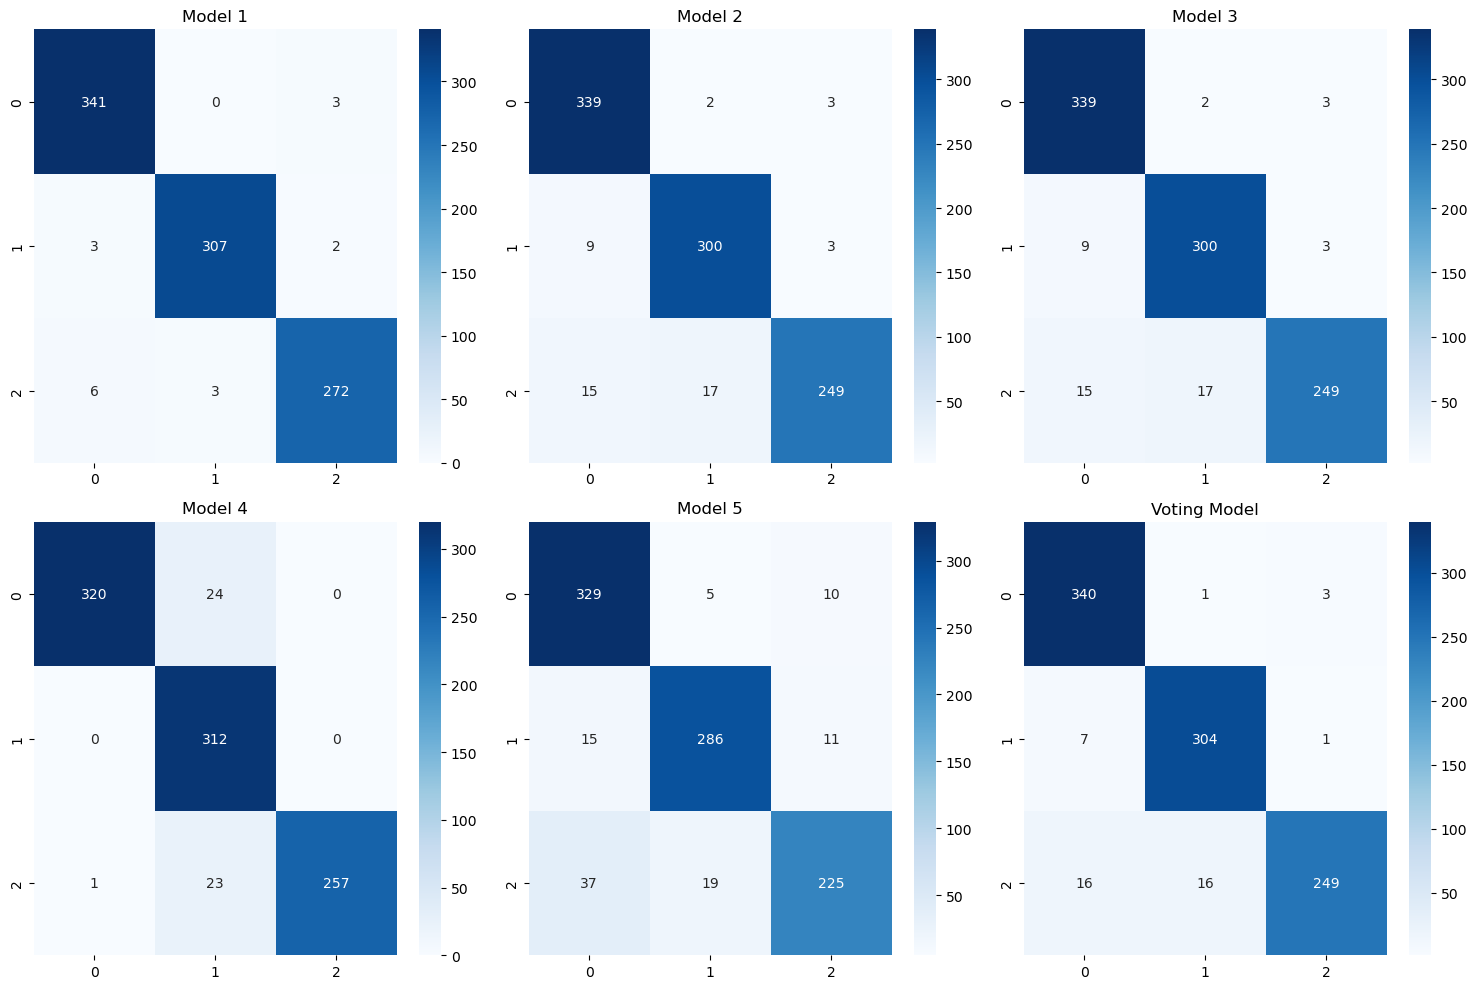

In [15]:
# Compute confusion matrices for individual models
cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)
cm3 = confusion_matrix(y_test, y_pred3)
cm4 = confusion_matrix(y_test, y_pred4)
cm5 = confusion_matrix(y_test, y_pred5)
cm6 = confusion_matrix(y_test, y_pred6)

# Plot confusion matrices using seaborn
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Model 1')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Model 2')

sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
axes[0, 2].set_title('Model 3')

sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Model 4')

sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Model 5')

sns.heatmap(cm6, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2])
axes[1, 2].set_title('Voting Model')

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [28]:
# Compute precision score for individual models
p1 = precision_score(y_test, y_pred1, average='weighted')
p2 = precision_score(y_test, y_pred2, average='weighted')
p3 = precision_score(y_test, y_pred3, average='weighted')
p4 = precision_score(y_test, y_pred4, average='weighted')
p5 = precision_score(y_test, y_pred5, average='weighted')
p6 = precision_score(y_test, y_pred6, average='weighted')

print("Precision of model_1:", p1)
print("Precision of model_2:", p2)
print("Precision of model_3:", p3)
print("Precision of model_4:", p4)
print("Precision of model_5:", p5)
print("Precision of Voting model:", p6)

Precision of model_1: 0.9819239367230641
Precision of model_2: 0.9488381659988385
Precision of model_3: 0.9488381659988385
Precision of model_4: 0.9552631294047766
Precision of model_5: 0.8985135807669989
Precision of Voting model: 0.9543626515648821


In [29]:
# Compute precision score for individual models
r1 = recall_score(y_test, y_pred1, average='weighted')
r2 = recall_score(y_test, y_pred2, average='weighted')
r3 = recall_score(y_test, y_pred3, average='weighted')
r4 = recall_score(y_test, y_pred4, average='weighted')
r5 = recall_score(y_test, y_pred5, average='weighted')
r6 = recall_score(y_test, y_pred6, average='weighted')

print("Recall of model_1:", r1)
print("Recall of model_2:", r2)
print("Recall of model_3:", r3)
print("Recall of model_4:", r4)
print("Recall of model_5:", r5)
print("Recall of Voting model:", r6)

Recall of model_1: 0.9818569903948773
Recall of model_2: 0.9477054429028815
Recall of model_3: 0.9477054429028815
Recall of model_4: 0.9487726787620064
Recall of model_5: 0.8964781216648879
Recall of Voting model: 0.9530416221985059


In [30]:
# Compute precision score for individual models
f1 = f1_score(y_test, y_pred1, average='weighted')
f2 = f1_score(y_test, y_pred2, average='weighted')
f3 = f1_score(y_test, y_pred3, average='weighted')
f4 = f1_score(y_test, y_pred4, average='weighted')
f5 = f1_score(y_test, y_pred5, average='weighted')
f6 = f1_score(y_test, y_pred6, average='weighted')

print("F1 Score of model_1:", r1)
print("F1 Score of model_2:", r2)
print("F1 Score of model_3:", r3)
print("F1 Score of model_4:", r4)
print("F1 Score of model_5:", r5)
print("F1 Score of Voting model:", r6)

F1 Score of model_1: 0.9818569903948773
F1 Score of model_2: 0.9477054429028815
F1 Score of model_3: 0.9477054429028815
F1 Score of model_4: 0.9487726787620064
F1 Score of model_5: 0.8964781216648879
F1 Score of Voting model: 0.9530416221985059


# Train each individual model on the entire dataset

In [16]:
model_1.fit(X, y)
model_2.fit(X, y)
model_3.fit(X, y)
model_4.fit(X, y)
voting_model.fit(X, y)

VotingClassifier(estimators=[('linear', SVC(kernel='linear')), ('rbf', SVC()),
                             ('poly', SVC(kernel='poly')),
                             ('sigmoid', SVC(kernel='sigmoid'))])

# Cross Validation

In [21]:
# Evaluate individual models using cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
scores_model_1 = cross_val_score(model_1, X, y, cv=5)
scores_model_2 = cross_val_score(model_2, X, y, cv=5)
scores_model_3 = cross_val_score(model_3, X, y, cv=5)
scores_model_4 = cross_val_score(model_4, X, y, cv=5)
scores_voting_model = cross_val_score(voting_model, X, y, cv=5)

KeyboardInterrupt: 

In [22]:
# Print the results
print(f'Model 1 Cross-Validation Scores: {scores_model_1.mean()}')
print(f'Model 2 Cross-Validation Scores: {scores_model_2.mean()}')
print(f'Model 3 Cross-Validation Scores: {scores_model_3.mean()}')

Model 1 Cross-Validation Scores: 0.9378373879174307
Model 2 Cross-Validation Scores: 0.9248098130968995
Model 3 Cross-Validation Scores: 0.9162657690939442


In [23]:
print(f'Model 4 Cross-Validation Scores: {scores_model_4.mean()}')

Model 4 Cross-Validation Scores: 0.5604128469656752


# Save individual models

In [24]:
dump(scaler, 'rice_scaler.joblib')
dump(model_1, 'linear.joblib')
dump(model_2, 'rbf.joblib')
dump(model_3, 'poly.joblib')
dump(model_4, 'sigmoid.joblib')
dump(voting_model, 'voting.joblib')

['voting.joblib']